## Playground

### Layer Class

In [103]:
import numpy as np

class Layer:
    def __init__(self, m_inputs: int, n_perceptrons: int, activation: str = 'relu'):
        self.m = m_inputs
        self.n = n_perceptrons                           
        self.weights_matrix = np.random.rand(self.m, self.n)
        self.biases_vector = np.zeros(self.n)
        self._set_activation(activation)
        self.inputs = None
        self.output = None
    
    def _set_activation(self, activation: str):
        if activation == 'relu':
            self.activation = self.relu
            self.activation_derivative = self.relu_derivative
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation == 'softmax':
            self.activation = self.softmax
            self.activation_derivative = self.softmax_derivative 
        elif activation == 'tanh':
            self.activation = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        exp_values = np.exp(x - np.max(x))
        return exp_values / exp_values.sum(axis=0, keepdims=True)

    def softmax_derivative(self, x):
        s = self.softmax(x)
        return s * (1 - s)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2
        
    def forward(self, inputs:list):
        self.inputs = inputs
        argument = np.dot(self.weights_matrix.T, inputs) + self.biases_vector
        activation = self.activation(argument)
        self.output = activation
        return activation

    def backward(self, delta, static_learn_rate, learn_rate_function, epoch_idx):
        learn_rate = None
        # Compute gradients
        dC_dw = np.outer(delta, self.inputs).T
        dC_db = delta
        # Apply Floating Learn Rate Strategy
        if callable(learn_rate_function):
            learn_rate = learn_rate_function(epoch_idx)
        else:
            learn_rate = static_learn_rate
        # Save the learn_rate
        self.learn_rate = learn_rate
        # Update weights and biases
        self.weights_matrix -= learn_rate * dC_dw
        self.biases_vector -= learn_rate * dC_db
        # Compute and store the delta for the next layer in the network
        delta_next = np.dot(self.weights_matrix, delta) * self.activation_derivative(self.inputs)
        return delta_next

### Sequential Network Class

In [102]:
class Sequential:
    def __init__(self, layers:list, cost="cce", tolerance=0):
        self.layers = layers
        self.cost = cost
        self.tolerance = tolerance
        self.epochs_accuracies = []
        self.epochs_learn_rates = []
        self.epochs_learn_rate = None

    def propagate(self, inputs:list):
        result = None
        for idx, layer in enumerate(self.layers):
            if idx == 0:
                result = layer.forward(inputs)
            else:
                result = layer.forward(result)
        return result

    def predict(self, inputs:list):
        results = []
        for x in inputs:
            results.append(self.propagate(x).flatten())
        return np.array(results)

    def back_propagate(self, y_true, learn_rate, learn_function, epoch_idx ):
        # Compute the delta for the output layer
        delta_L = None
        if self.cost == "cce":
            delta_L = self.layers[-1].output - y_true
        elif self.cost == "mse":
            delta_L = (self.layers[-1].output - y_true) * self.layers[-1].activation_derivative(self.layers[-1].output)
        # Backpropagate the delta through the layers
        for layer in reversed(self.layers):
            delta_L = layer.backward(delta_L, learn_rate, learn_function, epoch_idx)
            # Save the epochs learn rates
            self.epochs_learn_rate = (layer.learn_rate)

    def cce_loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        y_true = y_true.reshape(-1, 1)
        loss = - np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        return loss

    def calculate_accuracy(self, y_true, y_pred):
        if isinstance(y_true, (list, np.ndarray)):
            y_pred_class = np.argmax(y_pred)
            y_true_class = np.argmax(y_true)
            accuracy = 1 if abs(y_true_class - y_pred_class) <= self.tolerance else 0
            return accuracy
        else:
            accuracy = 1 if abs(y_true - y_pred) <= self.tolerance else 0
            return accuracy


    def fit(self, X_train, y_train, epochs, learn_rate=0.01, learn_function=False, functional_interval=10):
        for epoch in range(epochs):
            total_loss = 0.0
            total_accuracy = 0.0
            for inputs, target in zip(X_train, y_train):
                epoch_idx = (functional_interval/epochs)*epoch
                # Propagate forward and backward
                output = self.propagate(inputs)
                self.back_propagate(target, learn_rate, learn_function, epoch_idx)
                # Calculate loss and accuracy
                loss = self.cce_loss(target, output)
                accuracy = self.calculate_accuracy(target, output)
                # Sum the total loss and accuracy
                total_loss += loss
                total_accuracy += accuracy
            # Average loss and accuracy over the epoch
            avg_loss = total_loss / len(X_train)
            avg_accuracy = total_accuracy / len(X_train)
            # Save the epochs accuracy
            self.epochs_accuracies.append(np.round(avg_accuracy, 2))
            self.epochs_learn_rates.append(self.epochs_learn_rate)
            if epoch % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f} - Accuracy: {avg_accuracy:.4f}")

### Create Artificial Data

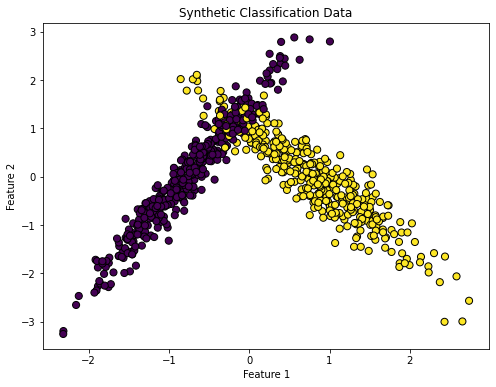

In [5]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to create and plot synthetic classification data
def create_classification_data():
    # Generate synthetic data
    X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0,
                               n_clusters_per_class=1, flip_y=0, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=50)
    plt.title('Synthetic Classification Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

    return X_train, X_test, y_train, y_test

# Create synthetic classification data
X_train, X_test, y_train, y_test = create_classification_data()

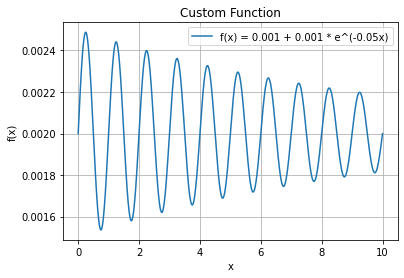

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def floating_rate(x):
    amplitude = 0.0005
    offset = 0.002
    frequency = 1  # Adjust the frequency as needed
    decay_rate = 0.1  # Adjust the decay rate as needed
    decay_term = np.exp(-decay_rate * x)
    return amplitude * np.sin(2 * np.pi * frequency * x) * decay_term + offset

# Generate x values from 0 to 10
x_values = np.linspace(0, 10, 1000)

# Calculate corresponding y values using the custom function
y_values = floating_rate(x_values)

# Plot the function
plt.plot(x_values, y_values, label='f(x) = 0.001 + 0.001 * e^(-0.05x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Custom Function')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
nn = Sequential([
    Layer(m_inputs=2, n_perceptrons=2, activation="relu"),
    Layer(m_inputs=2, n_perceptrons=6, activation="relu"),
    Layer(m_inputs=6, n_perceptrons=1, activation="sigmoid"),
], cost="cce", tolerance=0.15)

nn.fit(X_train=X_train, y_train=y_train, epochs=400, learn_rate=0.001, learn_function=floating_rate, functional_interval=10)

Epoch 1/400 - Loss: 0.2554 - Accuracy: 0.0000
Epoch 11/400 - Loss: 0.1422 - Accuracy: 0.2975
Epoch 21/400 - Loss: 0.1254 - Accuracy: 0.3600
Epoch 31/400 - Loss: 0.1180 - Accuracy: 0.7412
Epoch 41/400 - Loss: 0.1128 - Accuracy: 0.7600
Epoch 51/400 - Loss: 0.1085 - Accuracy: 0.7750
Epoch 61/400 - Loss: 0.1056 - Accuracy: 0.7887
Epoch 71/400 - Loss: 0.1038 - Accuracy: 0.7900
Epoch 81/400 - Loss: 0.1023 - Accuracy: 0.7925
Epoch 91/400 - Loss: 0.1006 - Accuracy: 0.7950
Epoch 101/400 - Loss: 0.0993 - Accuracy: 0.7975
Epoch 111/400 - Loss: 0.0986 - Accuracy: 0.7975
Epoch 121/400 - Loss: 0.0984 - Accuracy: 0.7975
Epoch 131/400 - Loss: 0.0986 - Accuracy: 0.7975
Epoch 141/400 - Loss: 0.0992 - Accuracy: 0.8025
Epoch 151/400 - Loss: 0.0999 - Accuracy: 0.8050
Epoch 161/400 - Loss: 0.1010 - Accuracy: 0.8075
Epoch 171/400 - Loss: 0.1030 - Accuracy: 0.8125
Epoch 181/400 - Loss: 0.1047 - Accuracy: 0.8225
Epoch 191/400 - Loss: 0.1065 - Accuracy: 0.8287
Epoch 201/400 - Loss: 0.1084 - Accuracy: 0.8375
Epo

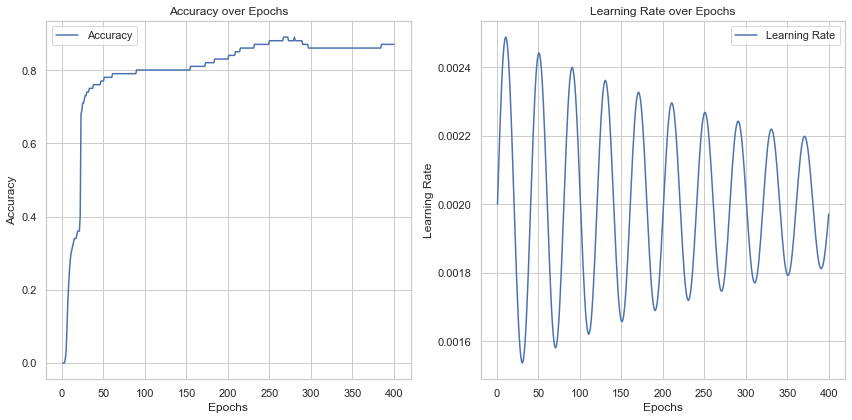

400


In [106]:
import seaborn as sns

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Accuracy Plot
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(nn.epochs_accuracies) + 1), y=nn.epochs_accuracies, label='Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Learning Rate Plot
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(nn.epochs_learn_rates) + 1), y=nn.epochs_learn_rates, label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

print(len(nn.epochs_learn_rates))